<a href="https://colab.research.google.com/github/razor08/Network-IDS-Paper/blob/master/NSL-KDD-Categorical/NSL_KDD_Multi_Category_k%3D6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [386]:
import sys
import keras
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import sklearn.preprocessing
from scipy.stats import zscore
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as metrics
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)


1.1.4
1.18.1
3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
0.24.1


In [387]:
#Loading training set into dataframe
df = pd.read_csv('KDDTrain+.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [388]:
#Loading testing set into dataframe
qp = pd.read_csv('KDDTest+.txt', header=None)
qp.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [389]:
#Reset column names for training set
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,subclass,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [390]:
#Reset column names for testing set
qp.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
qp.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,subclass,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [391]:
#accessing names of training columns
lst_names = df.columns # returns a list of column names
lst_names


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level'],
      dtype='object')

In [392]:
#accessing names of testing columns
testlst_names = qp.columns
testlst_names

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level'],
      dtype='object')

In [393]:
#Dropping the last columns of training set
df = df.drop('difficulty_level', 1) # we don't need it in this project
df.shape

(125973, 42)

In [394]:
#Dropping the last columns of testing set
qp = qp.drop('difficulty_level', 1)
qp.shape

(22544, 42)

In [395]:
df.isnull().values.any()

False

In [396]:
qp.isnull().values.any()

False

In [399]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.savefig('1')
    plt.show()

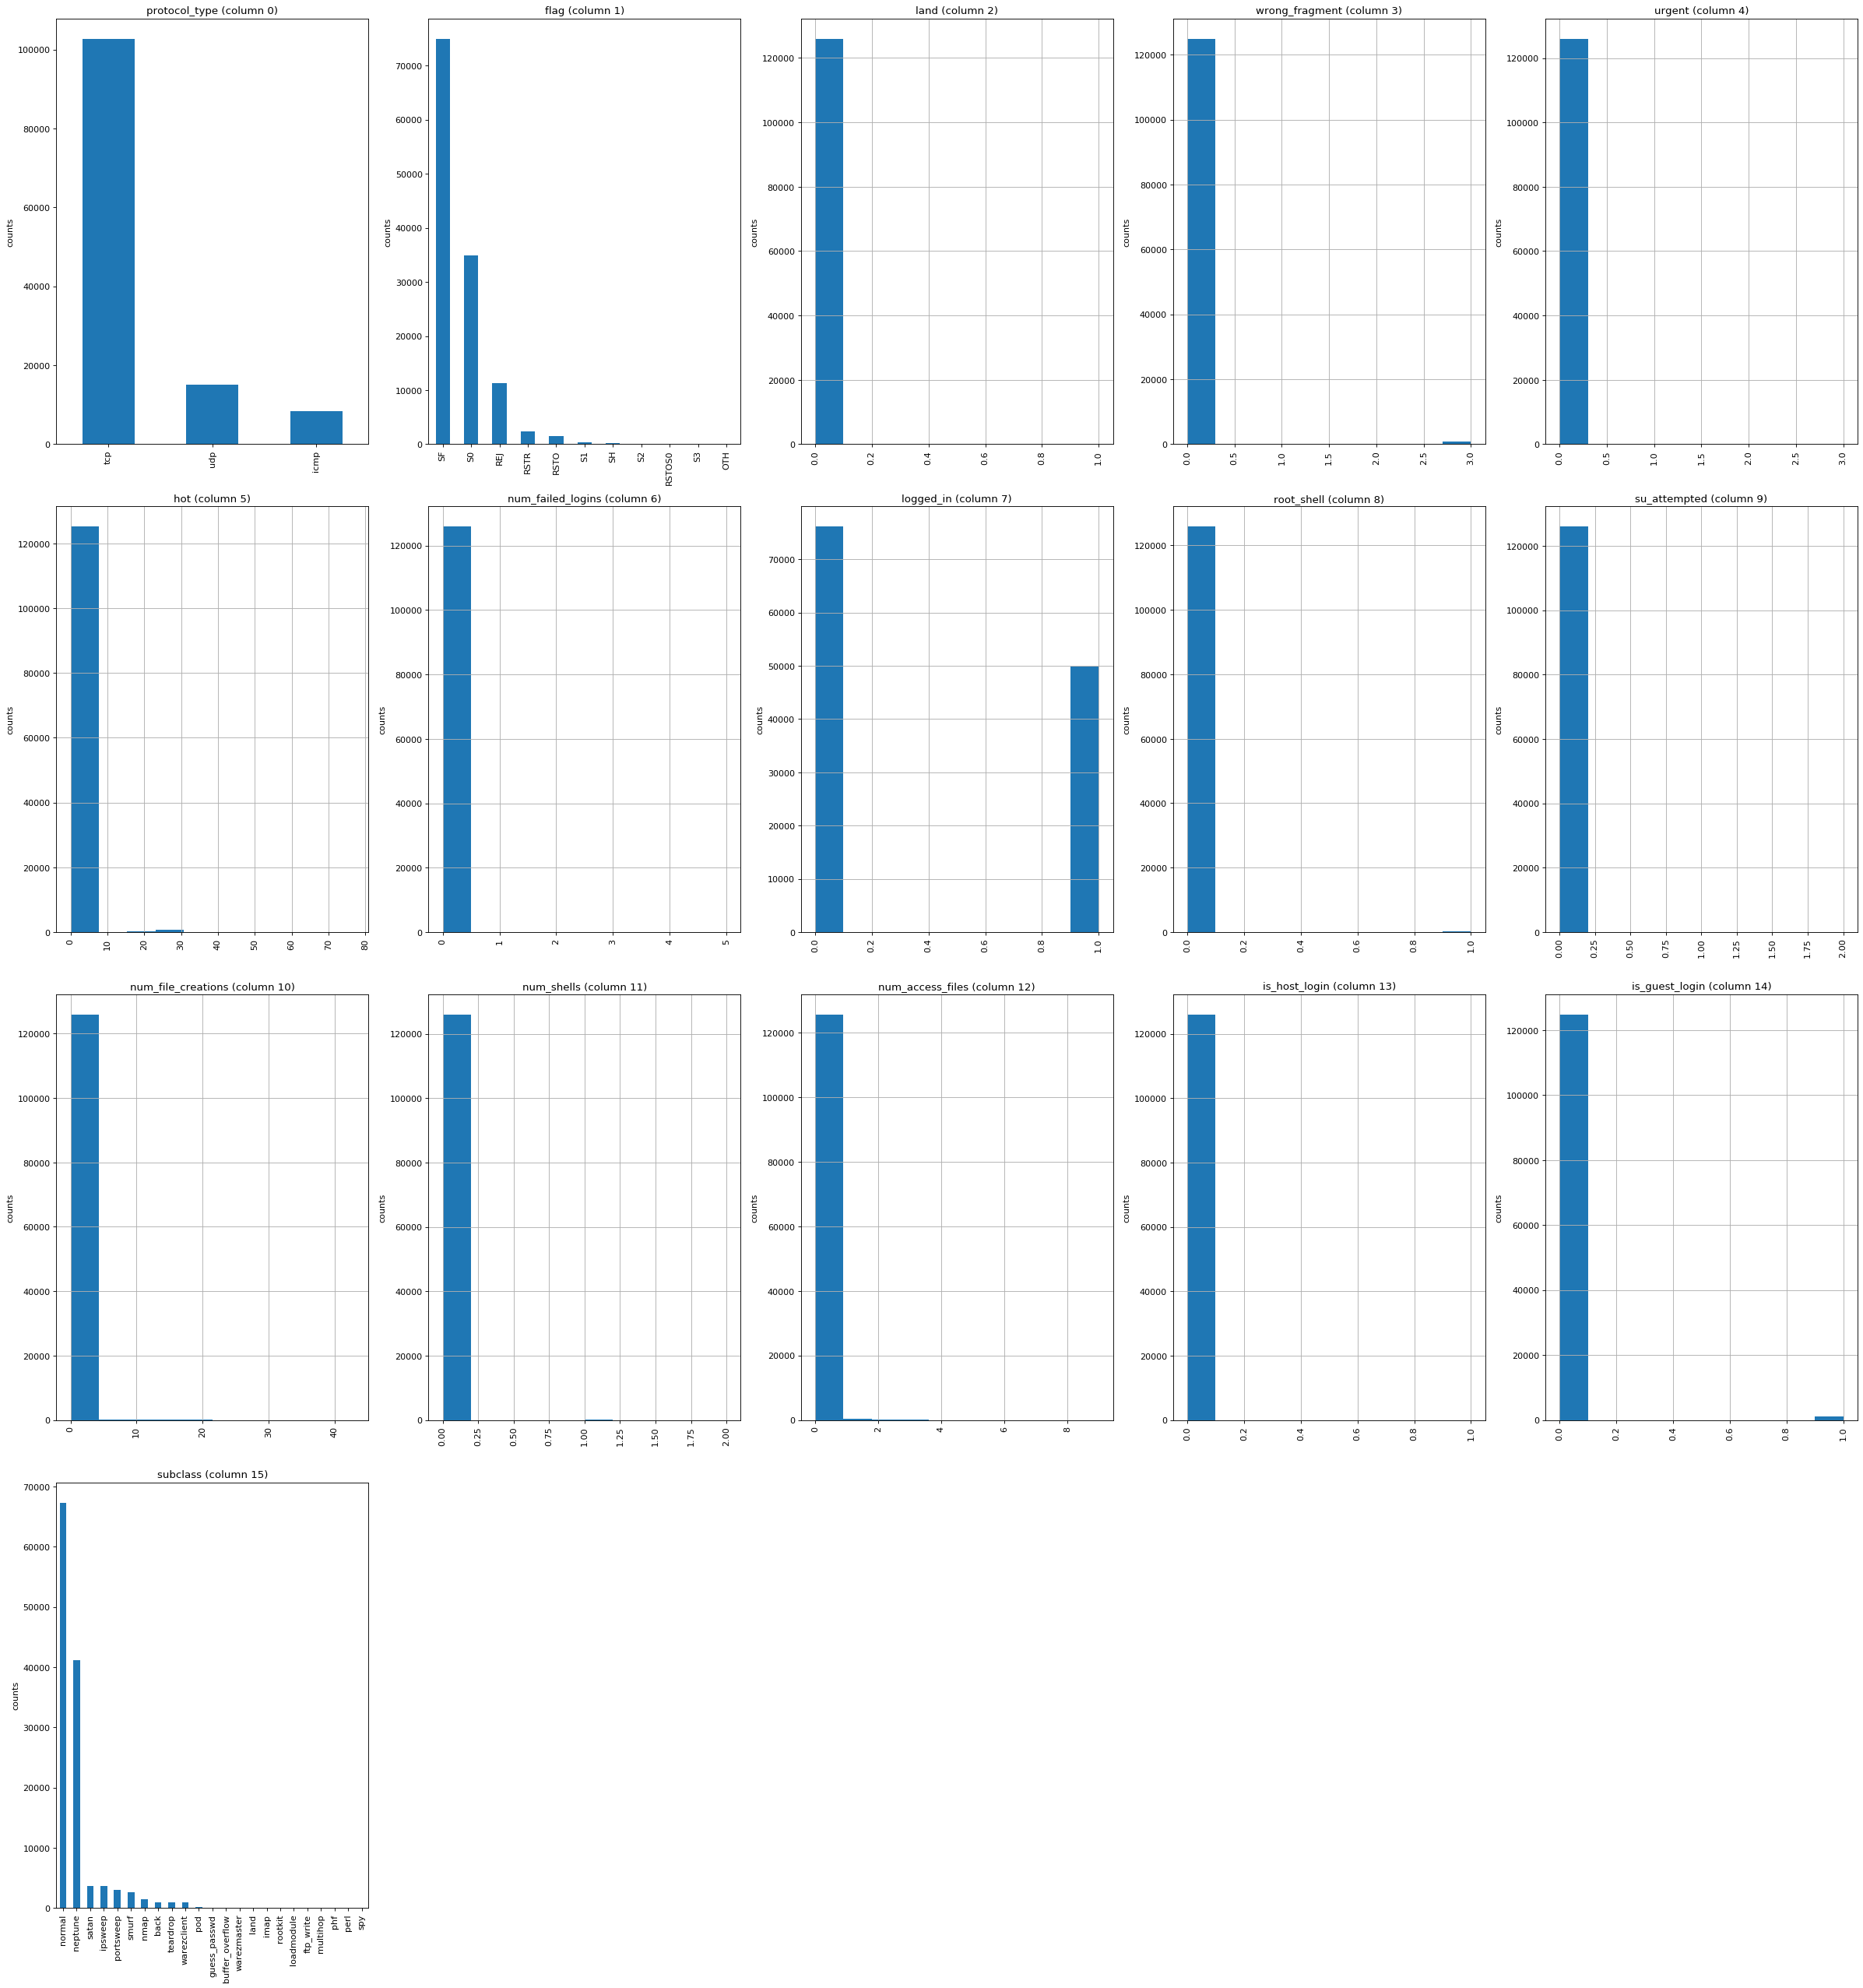

In [400]:
plotPerColumnDistribution(df, 25, 5)

In [401]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
#     filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for NSL-KDD Train', fontsize=15)
    plt.savefig('2')
    plt.show()

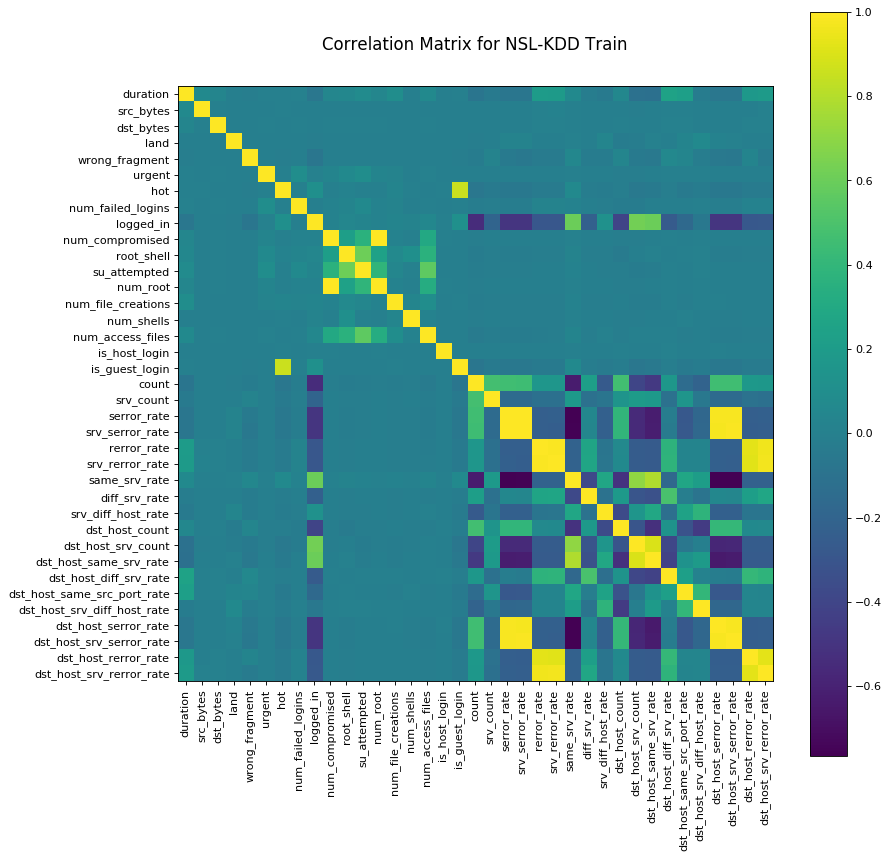

In [402]:
plotCorrelationMatrix(df, 12)

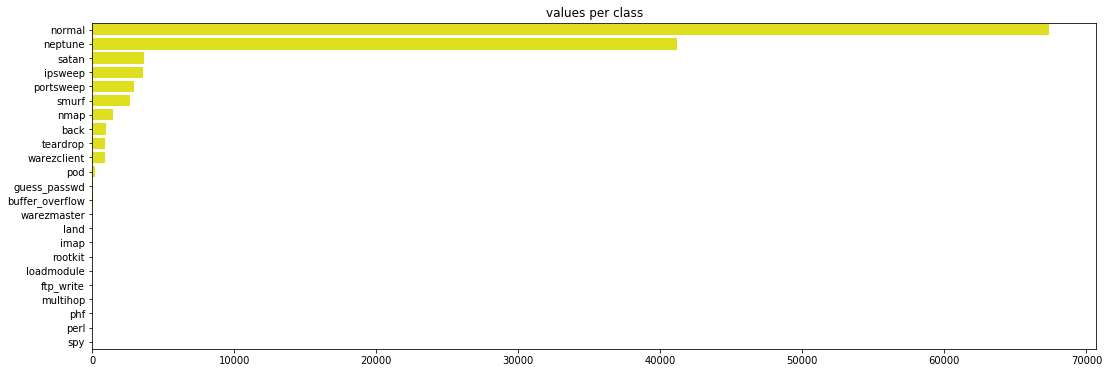

In [403]:
# print('number of classes:', df['subclass'].nunique())
# print('')
label_counts = df['subclass'].value_counts()
plt.figure(figsize=(18,6));
sns.barplot(y=label_counts.index, x=label_counts.values, color='Yellow');
plt.title('values per class');
plt.savefig('3')
# display(label_counts)

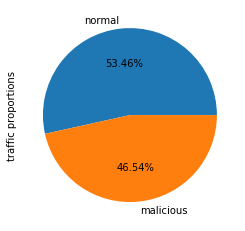

In [404]:
#binary traffic proportions
binary_class = []
for label in df['subclass']:
    if label !='normal':
        binary_class.append('malicious')
    else:
        binary_class.append('normal')
binary_class = pd.Series(binary_class)
plt.figure()
binary_class.value_counts().plot(kind='pie', label='traffic proportions', autopct='%.2f%%' )
plt.savefig('4')
plt.show()

In [405]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(df.subclass, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
subclass,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [407]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels,name):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        plt.savefig(name)
        
    return axs

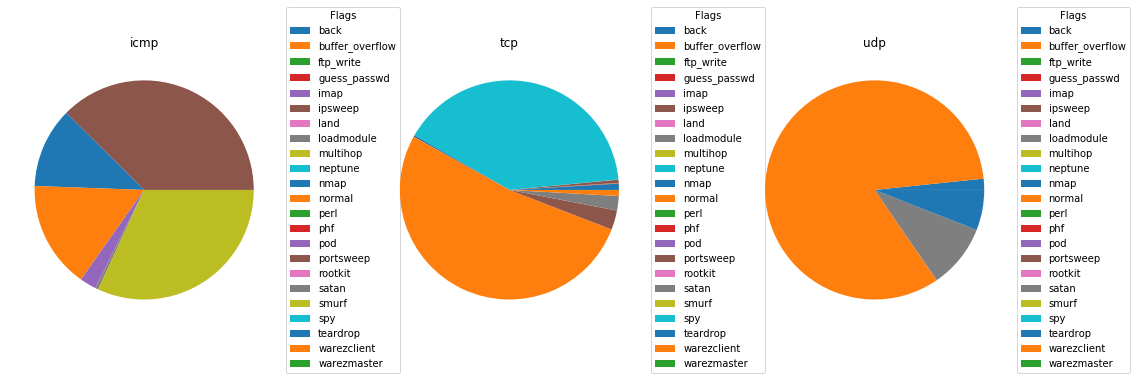

In [408]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'], '5')
plt.show()

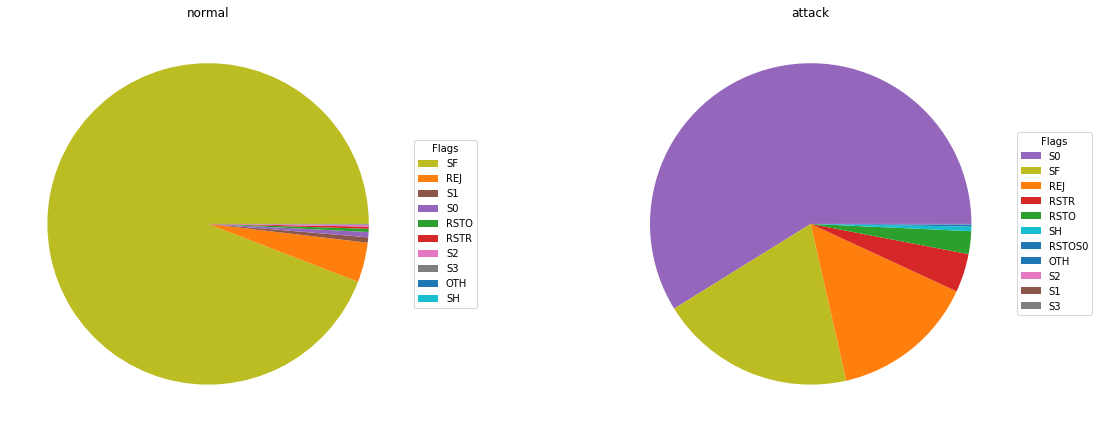

In [409]:
# map normal to 0, all attacks to 1
is_attack = df.subclass.map(lambda a: 0 if a == 'normal' else 1)
df['attack_flag'] = is_attack

# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'], '6')        
plt.show()

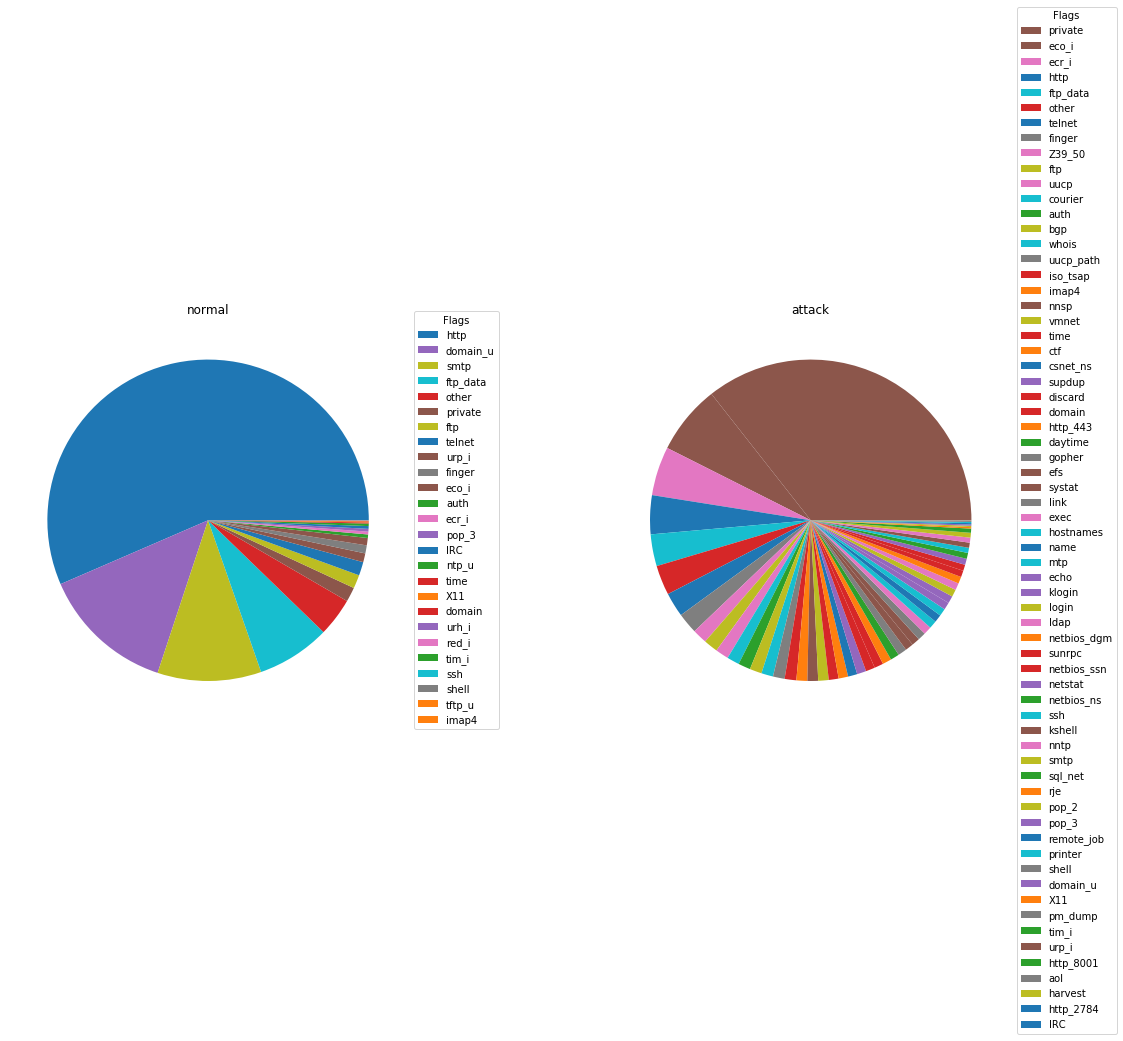

In [410]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'], '7')        
plt.show()

In [411]:
df = df.drop('attack_flag', axis = 1)
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'subclass'],
      dtype='object')

In [412]:
#defining col list
cols = ['protocol_type','service','flag']
cols

['protocol_type', 'service', 'flag']

In [413]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df


In [414]:
#Merging train and test data
combined_data = pd.concat([df,qp])

In [415]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

In [416]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [417]:
#Dropping subclass column for training set
tmp = combined_data.pop('subclass')

In [418]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [419]:
#Fixing labels for training set
classlist = []
check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

DoSCount=0
ProbeCount=0
U2RCount=0
R2LCount=0
NormalCount=0

for item in tmp:
    if item in check1:
        classlist.append("DoS")
        DoSCount=DoSCount+1
    elif item in check2:
        classlist.append("Probe")
        ProbeCount=ProbeCount+1
    elif item in check3:
        classlist.append("U2R")
        U2RCount=U2RCount+1
    elif item in check4:
        classlist.append("R2L")
        R2LCount=R2LCount+1
    else:
        classlist.append("Normal")
        NormalCount=NormalCount+1   

In [420]:
#Appending class column to training set
new_train_df["Class"] = classlist
new_train_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,Class
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,DoS
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,DoS
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal


In [421]:
new_train_df["Class"].value_counts()

Normal    77232
DoS       53387
Probe     14077
R2L        3702
U2R         119
Name: Class, dtype: int64

In [422]:
new_train_df.isnull().values.any()

False

In [423]:
y_train=new_train_df["Class"]
y_train

0        Normal
1        Normal
2           DoS
3        Normal
4        Normal
          ...  
22539    Normal
22540    Normal
22541       DoS
22542    Normal
22543     Probe
Name: Class, Length: 148517, dtype: object

In [424]:
y_train.isnull().values.any()

False

In [425]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,5.753774e-07,2.542106e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0.0,2.297162e-07,7.160648e-07,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0.0,3.952277e-05,6.346868e-06,0.0,0.0,0.0,0.019802,0.0,1.0,0.000134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0.0,3.043558e-08,3.206260e-08,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [224]:
#Bidirectional RNN
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, border_mode="same",activation="relu",input_shape=(122, 1)))
model.add(MaxPooling1D(pool_length=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False))) 
model.add(Reshape((128, 1), input_shape = (128, )))
    
model.add(MaxPooling1D(pool_length=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False))) 
    
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [225]:
for layer in model.layers:
    print(layer.output_shape)

(None, 122, 64)
(None, 24, 64)
(None, 24, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 5)
(None, 5)


In [226]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 122, 64)           7872      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 64)            256       
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               66048     
_________________________________________________________________
reshape_5 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 25, 1)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 1)             4         
__________

In [227]:
oos_pred = []
k_dict = {'accuracy' : [], 'detectionRate' : [], 'falsepositiverate' : [], 'confusionmatrix' : []}

In [228]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [229]:
for k in range(2,11,2):
    k_dict['accuracy'].append([])
    k_dict['confusionmatrix'].append([])
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    kfold.get_n_splits(combined_data_X,y_train)
    for train_index, test_index in kfold.split(combined_data_X,y_train):
        train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
        train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
#         print("train index:",train_index)
#         print("test index:",test_index)
    
        x_columns_train = new_train_df.columns.drop('Class')
        x_train_array = train_X[x_columns_train].values
        x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
        dummies = pd.get_dummies(train_y) # Classification
        outcomes = dummies.columns
        num_classes = len(outcomes)
        y_train_1 = dummies.values
    
        x_columns_test = new_train_df.columns.drop('Class')
        x_test_array = test_X[x_columns_test].values
        x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
        dummies_test = pd.get_dummies(test_y) # Classification
        outcomes_test = dummies_test.columns
        num_classes = len(outcomes_test)
        y_test_2 = dummies_test.values
    
   
        model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=5)
    
        pred = model.predict(x_test_2)
        pred = np.argmax(pred,axis=1)
        y_eval = np.argmax(y_test_2,axis=1)
        score = metrics.accuracy_score(y_eval, pred)
#         oos_pred.append(score)
        k_dict['accuracy'][-1].append(score)
        cm = confusion_matrix(y_eval, pred, labels=[0,1,2,3,4])
        k_dict['confusionmatrix'][-1].append(cm)
        print("Validation score: {}".format(score))
    

Train on 74258 samples, validate on 74259 samples
Epoch 1/5
74258/74258 [==============================] - 148s 2ms/step - loss: 0.1341 - acc: 0.9581 - val_loss: 0.0865 - val_acc: 0.9745
Epoch 2/5
74258/74258 [==============================] - 145s 2ms/step - loss: 0.0824 - acc: 0.9731 - val_loss: 0.0757 - val_acc: 0.9767
Epoch 3/5
74258/74258 [==============================] - 152s 2ms/step - loss: 0.0674 - acc: 0.9776 - val_loss: 0.0525 - val_acc: 0.9808
Epoch 4/5
74258/74258 [==============================] - 155s 2ms/step - loss: 0.0532 - acc: 0.9814 - val_loss: 0.0521 - val_acc: 0.9817
Epoch 5/5
74258/74258 [==============================] - 158s 2ms/step - loss: 0.0459 - acc: 0.9834 - val_loss: 0.0427 - val_acc: 0.9846
Validation score: 0.9846483254555003
Train on 74259 samples, validate on 74258 samples
Epoch 1/5
74259/74259 [==============================] - 164s 2ms/step - loss: 0.0447 - acc: 0.9853 - val_loss: 0.0384 - val_acc: 0.9864
Epoch 2/5
74259/74259 [==================

123764/123764 [==============================] - 240s 2ms/step - loss: 0.0160 - acc: 0.9937 - val_loss: 0.0168 - val_acc: 0.9929
Epoch 4/5
123764/123764 [==============================] - 241s 2ms/step - loss: 0.0166 - acc: 0.9937 - val_loss: 0.0172 - val_acc: 0.9943
Epoch 5/5
123764/123764 [==============================] - 240s 2ms/step - loss: 0.0157 - acc: 0.9939 - val_loss: 0.0184 - val_acc: 0.9935
Validation score: 0.9935361370338949
Train on 123765 samples, validate on 24752 samples
Epoch 1/5
123765/123765 [==============================] - 240s 2ms/step - loss: 0.0165 - acc: 0.9936 - val_loss: 0.0161 - val_acc: 0.9934
Epoch 2/5
123765/123765 [==============================] - 239s 2ms/step - loss: 0.0158 - acc: 0.9939 - val_loss: 0.0180 - val_acc: 0.9932
Epoch 3/5
123765/123765 [==============================] - 240s 2ms/step - loss: 0.0158 - acc: 0.9938 - val_loss: 0.0186 - val_acc: 0.9923
Epoch 4/5
123765/123765 [==============================] - 239s 2ms/step - loss: 0.0160 

133665/133665 [==============================] - 253s 2ms/step - loss: 0.0132 - acc: 0.9951 - val_loss: 0.0140 - val_acc: 0.9945
Validation score: 0.9944788580662537
Train on 133665 samples, validate on 14852 samples
Epoch 1/5
133665/133665 [==============================] - 253s 2ms/step - loss: 0.0133 - acc: 0.9950 - val_loss: 0.0121 - val_acc: 0.9958
Epoch 2/5
133665/133665 [==============================] - 254s 2ms/step - loss: 0.0129 - acc: 0.9950 - val_loss: 0.0128 - val_acc: 0.9952
Epoch 3/5
133665/133665 [==============================] - 253s 2ms/step - loss: 0.0135 - acc: 0.9951 - val_loss: 0.0117 - val_acc: 0.9958
Epoch 4/5
133665/133665 [==============================] - 254s 2ms/step - loss: 0.0131 - acc: 0.9951 - val_loss: 0.0123 - val_acc: 0.9958
Epoch 5/5
133665/133665 [==============================] - 254s 2ms/step - loss: 0.0130 - acc: 0.9951 - val_loss: 0.0171 - val_acc: 0.9941
Validation score: 0.9941422030702936
Train on 133665 samples, validate on 14852 samples


In [379]:
# Taking mean of all accuracies for certain k-values
accuracy = []
for k_acc in k_dict['accuracy']:
    accuracy.append(max(k_acc))
# accuracy

In [380]:
# F1-score calculation of all classes
f1_scores = []
for k_mat in k_dict['confusionmatrix']:
    f1_scores.append([])
    for i in range(len(k_mat)):
        f1 = []
        for j in range(5):
            pr = (k_mat[i][j][j])/sum(k_mat[i][j])
            s = 0
            for m in range(5):
                s+=k_mat[i][m][j]
            re = (k_mat[i][j][j])/s
            score = (2 * pr * re)/ (pr + re)
            f1.append(score)
        f1_scores[-1].extend(f1)


class_f1_scores = []
k = 2
for i in range(5):
    class_f1_scores.append([])
    for j in range(5):
        s = sum(f1_scores[i][j::5])
        class_f1_scores[-1].append(s/k)
    k+=2
            
        
# class_f1_scores     

In [381]:
# False positive Rate and Detection Rate calculation
false_positive_rate = []
detection_rate = []
for k_mat in k_dict['confusionmatrix']:
    false_positive_rate.append([])
    detection_rate.append([])
    for i in range(len(k_mat)):
        FP = k_mat[i].sum(axis=0) - np.diag(k_mat[i])  
        FN = k_mat[i].sum(axis=1) - np.diag(k_mat[i])
        TP = np.diag(k_mat[i])
        TN = k_mat[i].sum() - (FP + FN + TP)
        
        FPR = sum(FP)/sum(FP+TN)
        DR = sum(TP)/sum(TP + FP)
        false_positive_rate[-1].append(FPR)
        detection_rate[-1].append(DR)
        
    false_positive_rate[-1] = np.mean(false_positive_rate[-1])*100
    detection_rate[-1] = np.mean(detection_rate[-1])
    
# print(false_positive_rate)
# print(detection_rate)

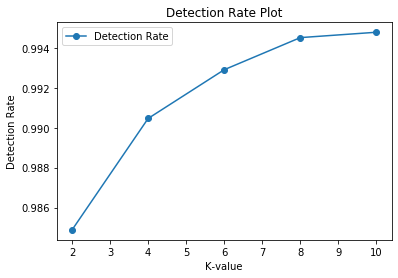

In [382]:
# Detection Rate Plot
k_vals = [2,4,6,8,10]
plt.figure()
plt.plot(k_vals, detection_rate, marker='o', label = 'Detection Rate')
plt.title('Detection Rate Plot')
plt.xlabel('K-value')
plt.ylabel('Detection Rate')
plt.legend()
plt.savefig('Detection Rate Plot')
plt.show()

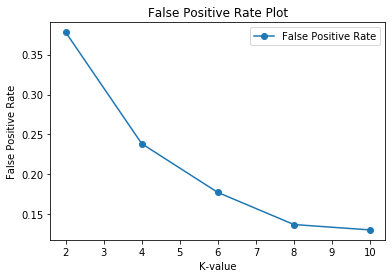

In [383]:
# False Positive Rate Plot
plt.figure()
plt.plot(k_vals, false_positive_rate, marker='o', label = 'False Positive Rate')
plt.title('False Positive Rate Plot')
plt.xlabel('K-value')
plt.ylabel('False Positive Rate')
plt.legend()
plt.savefig('False Positive Rate Plot')
plt.show()

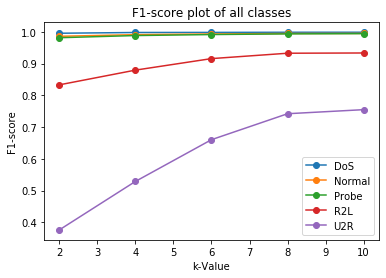

In [384]:
# F1- Score plot of all classes
DoS_F1, Normal_F1, Probe_F1, R2L_F1, U2R_F1 = [], [], [], [], []
for i in range(5):
    DoS_F1.append(class_f1_scores[i][0])
    Normal_F1.append(class_f1_scores[i][1])
    Probe_F1.append(class_f1_scores[i][2])
    R2L_F1.append(class_f1_scores[i][3])
    U2R_F1.append(class_f1_scores[i][4])

plt.figure()
plt.plot(k_vals, DoS_F1, marker='o', label = 'DoS')
plt.plot(k_vals, Normal_F1, marker='o', label = 'Normal')
plt.plot(k_vals, Probe_F1, marker='o', label = 'Probe')
plt.plot(k_vals, R2L_F1, marker='o', label = 'R2L')
plt.plot(k_vals, U2R_F1, marker='o', label = 'U2R')
plt.title('F1-score plot of all classes')
plt.xlabel('k-Value')
plt.ylabel('F1-score')
plt.legend()
plt.savefig('F1-score Plot')
plt.show()

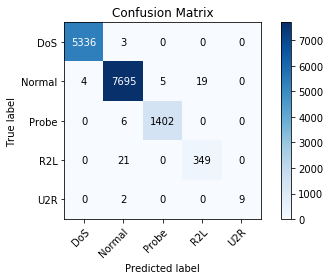

In [385]:
# Confusion Matrix Plot
class_names = ["DoS","Normal","Probe","R2L","U2R"]
# plt.figure(figsize = (15,10))
cmap=plt.cm.Blues
cm = k_dict['confusionmatrix'][4][7]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]), ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig('Confusion Matrix')
plt.show()

np.set_printoptions(precision=2)

In [378]:
# Table of Multiclass Classification Results
d = [['2', accuracy[0], detection_rate[0], false_positive_rate[0]], ['4', accuracy[1], detection_rate[1], false_positive_rate[1]], ['6', accuracy[2], detection_rate[2], false_positive_rate[2]], ['8', accuracy[3], detection_rate[3], false_positive_rate[3]], ['10', accuracy[4], detection_rate[4], false_positive_rate[4]], ['Average', np.mean(accuracy), np.mean(detection_rate), np.mean(false_positive_rate)]]
tab = pd.DataFrame(d,columns = ['K-value','Accuracy%','Detection Rate%','False Positive Rate%'])
tab

,K-value,Accuracy%,Detection Rate%,False Positive Rate%
0,2,0.985106,0.984877,0.378071
1,4,0.991220,0.990466,0.238356
2,6,0.993536,0.992910,0.177252
3,8,0.995529,0.994519,0.137021
4,10,0.995960,0.994788,0.130288
5,Average,0.992270,0.991512,0.212198


In [325]:
#Preparing X_train, Y_train
trainingdata = new_train_df.values
X_train = trainingdata[:125973,:-1]
Y_train = trainingdata[:125973,-1]

In [326]:
#Preparing X_test and Y_test
X_test = trainingdata[125973:,:-1]
Y_test = trainingdata[125973:,-1]

In [327]:
#PLA
clf = Perceptron (tol=1e-3) # init classifier
clf.fit(X_train, Y_train) # fit data
#############use and evaluate model##################
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.9744310288712661
Testing accuracy is: 0.7697835344215755


In [328]:
#PLA performance metrics
PLA_f1score = f1_score(Y_test, y_pred, average="macro")
PLA_precision = precision_score(Y_test, y_pred, average="macro")
PLA_recall = recall_score(Y_test, y_pred, average="macro")
PLA_accuracy = accuracy_score(Y_test, y_pred)

In [329]:
#Logistic Regression
clf = LogisticRegression (solver='liblinear', multi_class='auto') # use all default parameters
# predication and performance evaluation are the same as Perceptron
clf.fit(X_train, Y_train) # fit data
#############use and evaluate model##################
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.9762885697728878
Testing accuracy is: 0.7499556422995032


In [330]:
#Logistic Regression performance metrics
Logistic_f1 = f1_score(Y_test, y_pred, average="macro")
Logistic_precision = precision_score(Y_test, y_pred, average="macro")
Logistic_recall = recall_score(Y_test, y_pred, average="macro")
Logistic_accuracy = accuracy_score(Y_test, y_pred)

In [331]:
#Neural Network
clf = MLPClassifier (hidden_layer_sizes =(4,6,8)) # init classifier with three hidden layers with 4, 6, and 8 hidden units, respectively.
clf = MLPClassifier (hidden_layer_sizes =(200,)) # init classifier with one hidden layer with 200 hidden units
clf.fit(X_train, Y_train) # fit data
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.9980075095456963
Testing accuracy is: 0.8090844570617459


In [332]:
#NN performance metrics
Neural_f1 = f1_score(Y_test, y_pred, average="macro")
Neural_precision = precision_score(Y_test, y_pred, average="macro")
Neural_recall = recall_score(Y_test, y_pred, average="macro")
Neural_accuracy = accuracy_score(Y_test, y_pred)

In [333]:
#Decision Tree
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.999833297611393
Testing accuracy is: 0.7652146912704045


In [334]:
#Decision Tree Performance Metrics
Tree_f1 = f1_score(Y_test, y_pred, average="macro")
Tree_precision = precision_score(Y_test, y_pred, average="macro")
Tree_recall = recall_score(Y_test, y_pred, average="macro")
Tree_accuracy = accuracy_score(Y_test, y_pred)

In [335]:
#Uniform Aggregation for PLA, logistic regression, NN and decision trees
clf1 = Perceptron (tol=1e-3)
clf2 = LogisticRegression (solver='liblinear', multi_class='auto')
clf3 = MLPClassifier (hidden_layer_sizes =(4,6,8))
clf4 = DecisionTreeClassifier()

eclf1 = VotingClassifier(estimators=[('PLA', clf1), ('LR', clf2), ('NN', clf3),('Tree',clf4)], voting='hard')
eclf1 = eclf1.fit(X_train,Y_train)
train_acc = eclf1.score(X_train, Y_train) # mean acc on train data
test_acc = eclf1.score(X_test, Y_test) # mean acc on test data
y_pred = eclf1.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)


Training accuracy is: 0.9898787835488557
Testing accuracy is: 0.7648598296664301


In [336]:
#Performance Metric for Uniform aggregation
Uniform_f1 = f1_score(Y_test, y_pred, average="macro")
Uniform_precision = precision_score(Y_test, y_pred, average="macro")
Uniform_recall = recall_score(Y_test, y_pred, average="macro")
Uniform_accuracy = accuracy_score(Y_test, y_pred)

In [337]:
#Bagging with PLA
PLA_clf = Perceptron (tol=1e-3)

clf = BaggingClassifier(base_estimator = PLA_clf)
clf = clf.fit(X_train,Y_train)
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.978130234256547
Testing accuracy is: 0.7507540809084458


In [338]:
Bagging_f1 = f1_score(Y_test, y_pred, average="macro")
Bagging_precision = precision_score(Y_test, y_pred, average="macro")
Bagging_recall = recall_score(Y_test, y_pred, average="macro")
Bagging_accuracy = accuracy_score(Y_test, y_pred)

In [339]:
#AdaBoost with decision tree 

decision_clf = DecisionTreeClassifier()
clf = AdaBoostClassifier(decision_clf)
clf.fit(X_train,Y_train)
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)


Training accuracy is: 0.999833297611393
Testing accuracy is: 0.7614886444286728


In [340]:
#Performance Metrics for Adaboost
Ada_f1 = f1_score(Y_test, y_pred, average="macro")
Ada_precision = precision_score(Y_test, y_pred, average="macro")
Ada_recall = recall_score(Y_test, y_pred, average="macro")
Ada_accuracy = accuracy_score(Y_test, y_pred)

In [341]:
#Random Forest
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)
train_acc = clf.score(X_train, Y_train) # mean acc on train data
test_acc = clf.score(X_test, Y_test) # mean acc on test data
y_pred = clf.predict(X_test) # make prediction
print("Training accuracy is:", train_acc )
print("Testing accuracy is:", test_acc)

Training accuracy is: 0.999833297611393
Testing accuracy is: 0.7487136266855926


In [342]:
#Performance Metrics for Random Forest
RandomForest_f1 = f1_score(Y_test, y_pred, average="macro")
RandomForest_precision = precision_score(Y_test, y_pred, average="macro")
RandomForest_recall = recall_score(Y_test, y_pred, average="macro")
RandomForest_accuracy = accuracy_score(Y_test, y_pred)

In [343]:
#Displaying performance metrics 
data = [["PLA",PLA_accuracy,PLA_precision,PLA_recall,PLA_f1score],["Logistic Regression",Logistic_accuracy,Logistic_precision,Logistic_recall,Logistic_f1],["NN",Neural_accuracy,Neural_precision,Neural_recall,Neural_f1],["DTree",Tree_accuracy,Tree_precision,Tree_recall,Tree_f1],["Voting",Uniform_accuracy,Uniform_precision,Uniform_recall,Uniform_f1],["Bagging of PLA",Bagging_accuracy,Bagging_precision,Bagging_recall,Bagging_f1],["AdaBoost",Ada_accuracy,Ada_precision,Ada_recall,Ada_f1],["Random Forest",RandomForest_accuracy,RandomForest_precision,RandomForest_recall,RandomForest_f1]]
rt = pd.DataFrame(data,columns = ['','Mean Acc','Mean Precision','Mean Recall','Mean F1'])
rt

,,Mean Acc,Mean Precision,Mean Recall,Mean F1
0,PLA,0.769784,0.750920,0.577282,0.593128
1,Logistic Regression,0.749956,0.665561,0.490451,0.483570
2,NN,0.809084,0.750800,0.622719,0.655025
3,DTree,0.765215,0.728301,0.544479,0.556670
4,Voting,0.764860,0.851480,0.509835,0.517197
5,Bagging of PLA,0.750754,0.696027,0.507112,0.523922
6,AdaBoost,0.761489,0.782096,0.509929,0.537895
7,Random Forest,0.748714,0.752554,0.479888,0.490832


In [348]:
class_names = ["DoS","Normal","Probe","R2L","U2R"]

In [349]:
classifier = Perceptron (tol=1e-3)
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

 
    cm = confusion_matrix(y_true, y_pred)

   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)




Confusion matrix, without normalization
[[6161 1254   45    0    0]
 [ 103 9069  706    7    4]
 [ 123  336 1885   77    0]
 [   4 2466   12  220    5]
 [   1   40    2    5   19]]


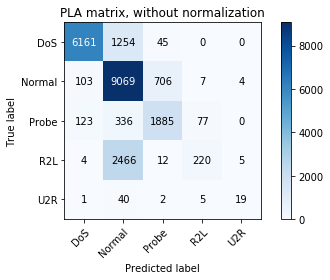

In [350]:
#PLA confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='PLA matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[6068 1378   14    0    0]
 [  88 9190  608    2    1]
 [ 167  593 1633   28    0]
 [   3 2687    3   14    0]
 [   0   65    0    0    2]]


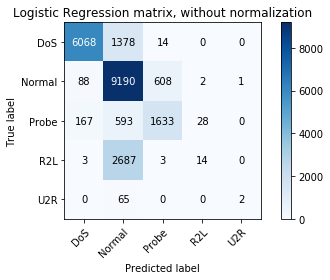

In [351]:
#Logistic Regression Matrix
classifier = LogisticRegression (solver='liblinear', multi_class='auto')
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Logistic Regression matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[5943 1361  145   11    0]
 [  66 9490  329    4    0]
 [ 357  547 1516    1    0]
 [   0 2381   75  251    0]
 [   0   58    2    7    0]]


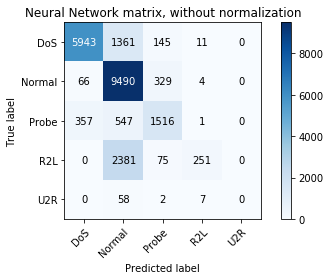

In [352]:
#NN confusion matrix
classifier = MLPClassifier (hidden_layer_sizes =(4,6,8))
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Neural Network matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[6061 1298   46   55    0]
 [  69 9213  601    6    0]
 [ 255  321 1840    5    0]
 [   0 1830  522  344   11]
 [   0   46    0    6   15]]


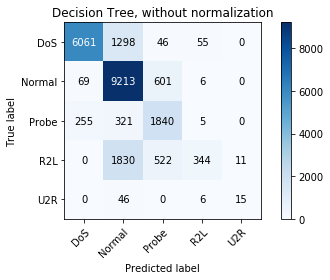

In [353]:
#Confusion Matrix for decision tree
classifier = DecisionTreeClassifier()
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Decision Tree, without normalization')
plt.show()

Confusion matrix, without normalization
[[6195 1258    7    0    0]
 [  88 9230  570    0    1]
 [ 178  538 1678   27    0]
 [   4 2495    2  206    0]
 [   1   56    0    3    7]]


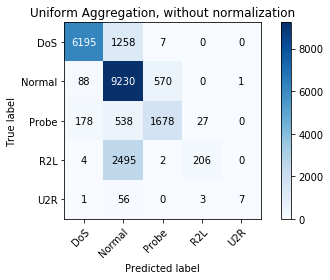

In [354]:
classifier = VotingClassifier(estimators=[('PLA', clf1), ('LR', clf2), ('NN', clf3),('Tree',clf4)], voting='hard')
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Uniform Aggregation, without normalization')
plt.show()

Confusion matrix, without normalization
[[6083 1362   15    0    0]
 [ 176 9209  502    0    2]
 [ 153  596 1574   98    0]
 [   4 2684    3   15    1]
 [   0   64    0    1    2]]


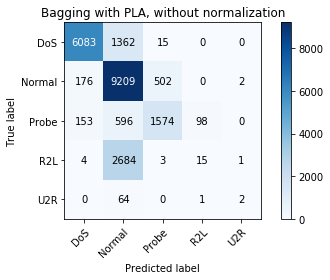

In [355]:
#Bagging with PLA confusion matrix
classifier = BaggingClassifier(base_estimator = PLA_clf)
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Bagging with PLA, without normalization')
plt.show()

Confusion matrix, without normalization
[[5847 1597   16    0    0]
 [  70 9617  199    1    2]
 [ 162  915 1344    0    0]
 [   0 2371    4  329    3]
 [   0   59    0    4    4]]


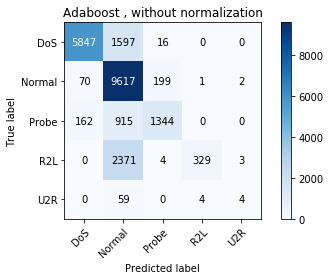

In [356]:
#Adaboost Confusion matrix

classifier = AdaBoostClassifier(decision_clf)
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Adaboost , without normalization')
plt.show()

Confusion matrix, without normalization
[[5888 1533   39    0    0]
 [  67 9634  185    1    2]
 [ 163  833 1425    0    0]
 [   0 2625    1   80    1]
 [   0   62    0    3    2]]


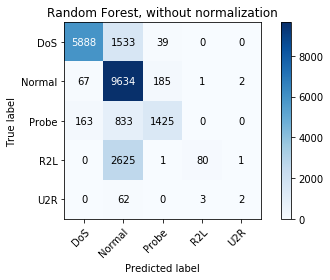

In [377]:
#Random Forest Confusion matrix

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, Y_train).predict(X_test)
plot_confusion_matrix(Y_test, y_pred, classes=class_names,title='Random Forest, without normalization')
plt.savefig('RFCM')
plt.show()